# Routine to read in available sounding data and interpolate to regular height interval (all years)


https://weather.uwyo.edu/upperair/sounding.html

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 12})
import xarray as xr
import pandas as pd
from datetime import datetime
from datetime import timedelta

# meteorology - specific
from metpy.calc import relative_humidity_from_dewpoint
from metpy.units import units
from siphon.simplewebservice.wyoming import WyomingUpperAir

import sys
sys.path.append('./scripts/')

from LIB_dates import generate_date_list
from LIB_request_WUA_sounding import check_for_WUA_soundings
from LIB_sounding_analysis import interpolate_soundings
from LIB_sounding_date_checks import grab_sounding_dates

### Specify parameters to retreive sounding data

season should be either 'winter', 'spring', 'summer', 'autumn', or 'all' for all year

In [155]:
# specify year, season, sounding hours
# specify site and height range
#===============================
years = [1998, 1999]
season = 'spring'
hours = [12]

station = 'PABR'

max_height = 6*units.kilometer
min_height =  0*units.kilometer
bin_width = 0.1*units.kilometer
#===============================

# julian day ranges for each season
season_bounds = {}
season_bounds['winter'] = {'start': 0,   'end': 91}
season_bounds['spring'] = {'start': 91,  'end': 182}
season_bounds['summer'] = {'start': 182, 'end': 274}
season_bounds['autumn'] = {'start': 274, 'end': 366}


# create date range for season
date_i = datetime.strptime(f"{year}-{int(season_bounds[season]['start'])}-{int(hours[0])}", '%Y-%j-%H')
date_f = datetime.strptime(f"{year}-{int(season_bounds[season]['end'])}-{int(hours[0])}", '%Y-%j-%H')
num_days = (date_f-date_i).days
date_list = generate_date_list(date_i=date_i, date_f=date_f, hourly=24)
len(date_list)

92

In [ ]:
### NEED TO MAKE BELOW RUN FOR ALL DOY IN SEASON, BUT CHECK AGAINST SOU TO SEE IF IT SHOULD GRAB DATA OR IF DATA DOES NOT EXIST



In [168]:
doy_soundings = doy[(doy>(season_bounds[season]['start']))&
                            (doy<=(season_bounds[season]['end']))]

len(doy_soundings)

91

### Retrieve and interpolate data

In [156]:
# all_RH = np.empty([60, 5, len(years)])# np.array([])
# all_T = np.array([])
# all_dates = np.array([])
# all_doy = np.array([])



for yy, year in enumerate(years):
    
#     all_RH_per_year = np.array([])
#     all_T_per_year = np.array([])

    # find all julian days (/hours) with soundings for given year
    doy, sou, year = grab_sounding_dates(csv=f'./sounding_checks/checked_{year}0101Z00_{year}1231Z23_hourly6.csv', hours=hours)
    days_with_soundings = doy[sou==1]

    # crop days to specified season
    if str(season) == 'all':
        doy_soundings = days_with_soundings
    else:
        doy_soundings = doy[(doy>(season_bounds[season]['start']))&
                            (doy<=(season_bounds[season]['end']))]
        
#         doy_soundings = days_with_soundings[(days_with_soundings>(season_bounds[season]['start']))&
#                                               (days_with_soundings<=(season_bounds[season]['end']))]
        
        
    for ii in range(len(doy_soundings)):

        # create date
        jdoy = int(doy_soundings[ii]) # round down to julian day
        hour = int(24*(doy_soundings[ii]%1)) # grab hours
        date = datetime.strptime(f'{year}-{jdoy}-{hour}', '%Y-%j-%H')

        print(date)

        # request data using siphon
        # try request multiple times in case there is error with first
        num_tries = 5
        for attempt in range(num_tries):
            try:
                df = WyomingUpperAir.request_data(date, station)
                worked = True
            except:
                worked = False
            if worked == True:
                break
        if worked == False:
            df = []
            print(f"No data available for {date}")

        # if data request was succesful:
        # pull out T, Td, H and calculate RH
        #-----------------------------------
        if len(df) > 0:

            # assign units to all data
            height = df['height'].values * units(df.units['height']).to(units.kilometer)
            temperature = df['temperature'].values * units(df.units['temperature'])
            dewpoint = df['dewpoint'].values * units(df.units['dewpoint'])

            # crop all to below 10 km
            H = height[height < 10*units.kilometer]
            T = temperature[height < 10*units.kilometer]
            Td = dewpoint[height < 10*units.kilometer]

            # calculate relative humidity
            RH = relative_humidity_from_dewpoint(T, Td).to('percent')

        # interpolate 
        #-----------------------------------  

        try:
            [new_RH, new_T], new_H, edges = interpolate_soundings(variable = [RH, T], heights = H, 
                                                                  bin_width = bin_width, min_height = min_height, 
                                                                  max_height = max_height, method = 'mean', 
                                                                  suppress_plots = True, suppress_prints = True)
            
            if yy == 0 and ii == 0:
                all_RH = np.zeros([len(new_RH), num_days, len(years)])
    
            for rr, rh in enumerate(new_RH):
                all_RH[rr, ii, yy] = new_RH[rr]*100
            
            
#             all_RH = np.append(all_RH, new_RH)
#             all_T = np.append(all_T, new_T)
            
#             all_RH_per_year = np.append(all_RH_per_year, new_RH)
#             all_T_per_year = np.append(all_T_per_year, new_T)
            
            
#             all_dates = np.append(all_dates, date)
#             all_doy = np.append(all_doy, doy_soundings[ii])

        except:
            print(f'  - issue with retrieval on {date}')
            
            # fill entries with nans if issue arises with data retreival
            for rr, rh in enumerate(new_RH):
                all_RH[rr, ii, yy] = np.nan

#     # reshape to dimensions: date, height
#     RH = np.reshape(all_RH, (int(len(all_RH)/len(new_H)), len(new_H)))
#     T = np.reshape(all_T, (int(len(all_T)/len(new_H)), len(new_H)))

#     # create grids to plot with pcolormesh
#     H, dates = np.meshgrid(new_H.magnitude, all_dates)
#     H, DOY = np.meshgrid(new_H.magnitude, all_doy)

1998-04-01 12:00:00
1998-04-02 12:00:00
1998-04-03 12:00:00
1998-04-04 12:00:00
1998-04-05 12:00:00
1998-04-06 12:00:00
1998-04-07 12:00:00
1998-04-08 12:00:00
1998-04-09 12:00:00
1998-04-10 12:00:00
1998-04-11 12:00:00
1998-04-12 12:00:00
1998-04-13 12:00:00
1998-04-14 12:00:00
1998-04-15 12:00:00
1998-04-16 12:00:00
1998-04-17 12:00:00
1998-04-19 12:00:00
1998-04-20 12:00:00
1998-04-21 12:00:00
1998-04-22 12:00:00
1998-04-23 12:00:00
1998-04-24 12:00:00
1998-04-25 12:00:00
1998-04-26 12:00:00
1998-04-27 12:00:00
1998-04-28 12:00:00
1998-04-29 12:00:00
1998-04-30 12:00:00
1998-05-01 12:00:00
1998-05-02 12:00:00
1998-05-03 12:00:00
1998-05-05 12:00:00
1998-05-06 12:00:00
1998-05-07 12:00:00
1998-05-08 12:00:00
1998-05-09 12:00:00
1998-05-10 12:00:00
1998-05-11 12:00:00
1998-05-12 12:00:00
1998-05-13 12:00:00
1998-05-14 12:00:00
1998-05-15 12:00:00
1998-05-16 12:00:00
1998-05-19 12:00:00
1998-05-20 12:00:00
1998-05-21 12:00:00
1998-05-22 12:00:00
1998-05-23 12:00:00
1998-05-24 12:00:00


### plot seasonal relative humidity and temperatures

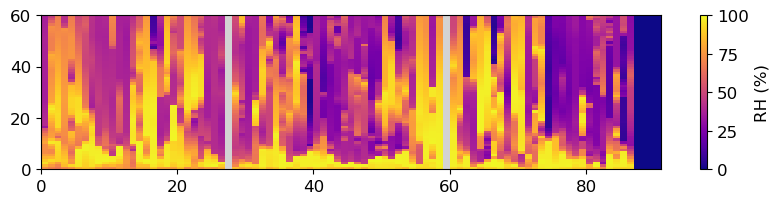

In [162]:

fig, ax = plt.subplots(figsize=(10,2))
ax.set_facecolor('lightgray')
rh = ax.pcolormesh(all_RH[:,:,1], vmin=0, vmax=100, cmap='plasma')
plt.colorbar(rh, label='RH (%)')



### Plot frequency of RH threshold passed seasonall as a function of height

ValueError: x and y must have same first dimension, but have shapes (1,) and (60,)

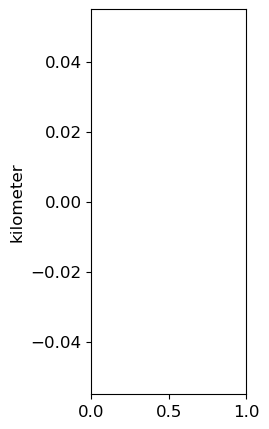

In [4]:
#===========================
rh_thresh = 98*units.percent
#===========================

rh_freq = 100*np.sum(RH>=rh_thresh, axis=0)/RH.shape[0]

fig, ax = plt.subplots(figsize=(2,5))
ax.plot(rh_freq, new_H, color='k', lw = 2, label='winter')
ax.set_title(f'RH >= {rh_thresh}')
ax.set_xlabel('frequency (%)')

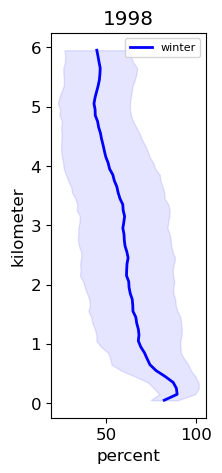

In [13]:

def plot_var_spread(ax, var, color='red', label = 'winter'):
    ax.plot(np.mean(var, axis=0), new_H, color=COLOR, lw = 2, label=label)
#     ax.plot(np.mean(var.magnitude, axis=0)-np.std(var.magnitude, axis=0), new_H, color=COLOR, lw = 0.5)
#     ax.plot(np.mean(var.magnitude, axis=0)+np.std(var.magnitude, axis=0), new_H, color=COLOR, lw = 0.5)
    ax.fill_betweenx(new_H,np.mean(var.magnitude, axis=0)-np.std(var.magnitude, axis=0), np.mean(var.magnitude, axis=0)+np.std(var.magnitude, axis=0),
                    alpha=0.1, zorder=-1, color=COLOR)
    
    
    
fig, ax = plt.subplots(figsize=(2,5))

#==========
VAR = RH
#==========

COLOR = 'blue'
var = VAR
plot_var_spread(ax, var, color=COLOR, label = 'winter')

# COLOR = 'dodgerblue'
# var = VAR[np.where(all_doy==90)[0][0]:np.where(all_doy==182)[0][0], :]
# plot_var_spread(ax, var, color=COLOR, label = 'spring')

# COLOR = 'indianred'
# var = VAR[np.where(all_doy==182)[0][0]:np.where(all_doy==274)[0][0], :]
# plot_var_spread(ax, var, color=COLOR, label = 'summer')

# COLOR = 'darkorange'
# var = VAR[np.where(all_doy==274)[0][0]:, :]
# plot_var_spread(ax, var, color=COLOR, label = 'autumn')


ax.set_title(f'{year}')
plt.legend(fontsize=8)
